# Operations Performance & Trend Analysis

## Data Loading

In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 



plt.style.use('default')




In [28]:
orders = pd.read_csv('../data/olist_orders_dataset.csv')
customers = pd.read_csv('../data/olist_customers_dataset.csv')


In [29]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [30]:
orders.shape

(99441, 8)

In [31]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [32]:
orders['order_purchase_timestamp'] =pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(
    orders['order_delivered_customer_date'],
    errors='coerce'
)

# Keep only delivered orders with valid delivery dates

orders_clean = orders[
    (orders['order_status'] == 'delivered') &
    (orders['order_delivered_customer_date'].notna())
].copy()

orders_clean.shape

(96470, 8)

In [33]:
orders_clean['delivery_time_days'] = (
    orders_clean['order_delivered_customer_date'] - 
    orders_clean['order_purchase_timestamp']
).dt.days

orders_clean[['delivery_time_days']].describe()

,delivery_time_days
count,96470.000000
mean,12.093604
std,9.551380
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


In [34]:
orders_enriched = orders_clean.merge(
    customers[['customer_id', 'customer_state']],on='customer_id',how='left'
)

orders_enriched.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,13,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,13,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2,SP


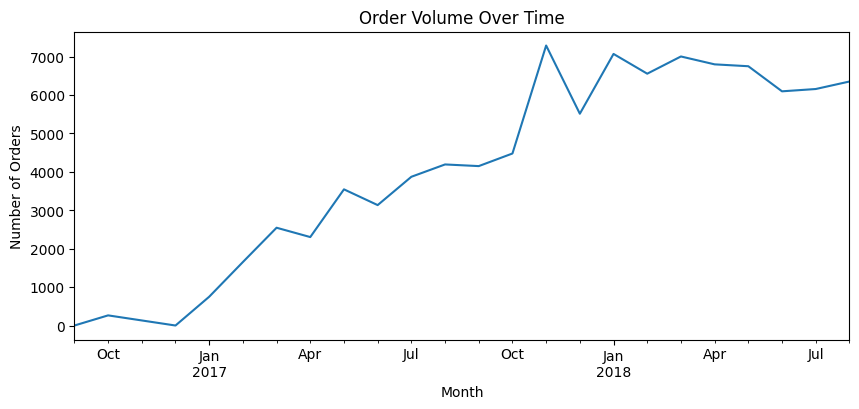

In [35]:
daily_orders = (
    orders_enriched
    .groupby(orders_enriched['order_purchase_timestamp'].dt.to_period('M'))
    .size()
)

daily_orders.plot(kind='line', figsize=(10,4), title='Order Volume Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()


In [36]:
state_delivery = (
    orders_enriched
    .groupby('customer_state')['delivery_time_days']
    .mean()
    .sort_values(ascending=False)
)
state_delivery.head(10)

customer_state
RR    28.975610
AP    26.731343
AM    25.986207
AL    24.040302
PA    23.316068
MA    21.117155
SE    21.029851
CE    20.817826
AC    20.637500
PB    19.953578
Name: delivery_time_days, dtype: float64

## Key Insights

Order volume shows a clear growth trend over time, indicating increasing operational load

Certain states consistently exhibit higher average delivery times, suggesting regional capacity or logistics constraits.

Delivery performance varies significatntly across regions, highlightining opportunities for targeted operational improvements.
